In [1]:
#default_exp node

In [2]:
#hide
#workaround to make relative imports inside notebook
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

# Dependencies

In [30]:
#export
import d6tflow

import os
from pathlib import Path
from warnings import warn
from collections import defaultdict

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import FunctionTransformer

from scipy import sparse
import numpy as np

# Input handling
> fucntionalities to handle inputs from tasks

In [101]:
#export
#TODO: define node name validaton rules
def _validate_name(name):
    '''
    function to validate node names.
    for now, any name is accepeted.
    '''
    return name


# Nodes
> Node InputTransformer and NodeTransformer, classes to wrap sklearn estimators and compose final DAGEstimator

In [6]:
#export
def _validate_input_nodes(input_nodes, child_name):
    '''
    checks if input nodes are valid (NodeTransformer).
    If not NodeTransformer but valid BaseEstimator instance, wrapps BaseEstimator in NodeTransformer
    '''
        
    processed_nodes = []
    for node in input_nodes:
        if isinstance(node, NodeTransformer):
            processed_nodes.append(node)
        
        elif isinstance(node, BaseEstimator):
            node = NodeTransformer(node, 'Parent' + child_name)
            process_nodes.append()

## Cache handler

## BaseNode

In [83]:
#export
class BaseNode(BaseEstimator):
    '''
    Base class for nodes
    every child must have a self.estimator and self.name attribute, otherwise getattr will
    raise an AttributeError
    '''    
    
    def __getattr__(self, attr):        
        return getattr(self.estimator, attr)
    
    def __repr__(self,):
        return self.name
    
    @property
    def estimator(self):
        if self.cached_estimator:
            #pickle load estimator
            return __estimator
        else:
            return self.__estimator
            
        

## InputTransformer

In [113]:
#export
class InputTransformer(BaseNode, TransformerMixin):
    
    def __init__(self, name = None):
                                        
        if name is None:
            self.name = str(id(self)) + '__input'
        else:
            self.name = _validate_name(name) + '__input'
                
        self.__cache = None
        return    
    
    @property
    def cache(self,):
        if self.__cache is None:
            raise NotFittedError('InputNode is not fitted yet. Call fit with its respective input value prior to calling transform or get_input')
        return self.__cache
    
    def fit(self, X, **kwargs):
        self.__cache = X
        return self
    
    def transform(self, **kwargs):
        return self.cache
    
    def get_input(self):
        return self.transform()

## NodeTransformer

In [114]:
#export
class NodeTransformer(BaseNode):
        
    def __init__(self, estimator, input_nodes = [], name = None, transform_method = 'transform'):
        
        self.estimator = estimator
        
        if not isinstance(input_nodes, (list, tuple)) and (len(input_nodes) > 0):
            raise TypeError(f'input_nodes should be a list or tuple with length greater than 0, got {input_nodes}')
        self.input_nodes = input_nodes
        
        if name is None:
            self.name = 'Task' + str(id(self))
        else:
            self.name = _validate_name(name)                                        
        
        self.transform_method = transform_method                
        return
    
    def transform(self, X, **kwargs):        
        return getattr(self.estimator, self.transform_method)(X, **kwargs)

# ConcatenateNode

In [115]:
#export

def _concat(X):
    
    '''
    concatenate function, handles mixed sparse and dense
    '''

    if not isinstance(X, (tuple, list)):
        raise TypeError(f'X must be list or tuple, got {type(X)}')

    X = list(X)
    for i in range(len(X)):
        if len(X[i].shape) < 2:
            X[i] = X[i].reshape(-1,1)
    
    if any([sparse.issparse(x) for x in X]):
        X = sparse.hstack(X)
    else:                
        X = np.hstack(X)

    return X

class ConcatenateNode(NodeTransformer):
    '''
    transformer to concatenate (hstack) arrays in a tuple or list
    '''
    def __init__(self, input_nodes, name = None):        
        super().__init__(FunctionTransformer(_concat), input_nodes = input_nodes, name = name)
        return        

# CustomYNode

In [116]:
class CustomYNode(NodeTransformer):
    '''
    recieves X inputs and y inputs, that is, the learning task (y) can be defined as the output of
    some node, as well as the input values (X)
    '''
    pass

# Dask DAG Example

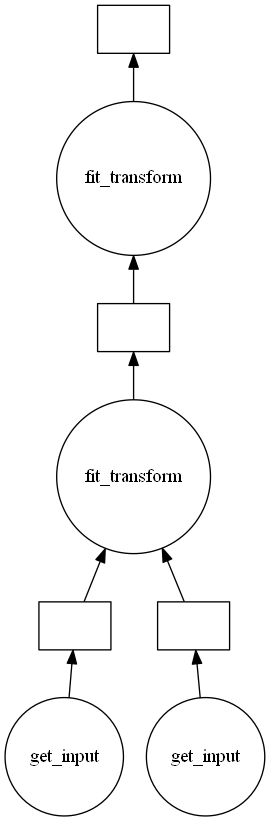

In [118]:
from dask import delayed
input1 = InputTransformer()
input2 = InputTransformer()
concat1 = ConcatenateNode([input1,input2])

node1 = NodeTransformer(FunctionTransformer(lambda x: x+1), [concat1])



in1 = delayed(input1.get_input)()
in2 = delayed(input2.get_input)()
out = delayed(concat1.fit_transform)([in1, in2])
out = delayed(node1.fit_transform)(out)


x = np.ones(10)
y = np.random.randn(10)

input1.fit(x)
input2.fit(y)

out.compute()

# Export

In [24]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted d6tflow-sklearn.ipynb.
Converted dag.ipynb.
Converted node.ipynb.
Converted utils.ipynb.
